This notebook implements finite difference propagation and compares its performance against Fresnel integral-based multislice simulation. Refer to the following paper for mathematical details:
1.	L. Melchior and T. Salditt, "Finite difference methods for stationary and time-dependent X-ray propagation," Optics Express 25, 32090– (2017).

In [60]:
import numpy as np
import dxchange
import matplotlib.pyplot as plt
from tqdm import tqdm
from pyfftw.interfaces.numpy_fft import fft2, ifft2, fftshift, ifftshift
from scipy.misc import imresize
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage.filters import laplace, convolve

In [61]:
PI = 3.1415927
def plot_img(a):
    plt.figure()
    plt.imshow(a)
    plt.show()

def plot_mod_and_phase(arr, figsize=(12, 5), title=None, unwrap=False):
    
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(1, 2, 1)
    subfig1 = ax1.imshow(np.abs(arr))
    plt.colorbar(subfig1)
    plt.title('Modulus')
    ax2 = fig.add_subplot(1, 2, 2)
    phase_term = np.angle(arr)
    if unwrap:
        phase_term = np.unwrap(phase_term)
    subfig2 = ax2.imshow(phase_term)
    plt.colorbar(subfig2)
    plt.title('Phase')
    if title is not None:
        plt.suptitle(title)
    plt.show()

Again we have our MVP phantom object i.e. the cone model.

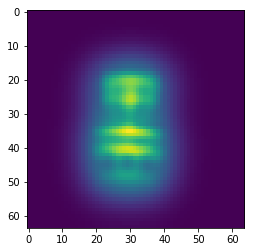

In [62]:
# read in object
grid_delta = np.load('phantom/grid_delta_adhesin.npy')
grid_beta = np.load('phantom/grid_beta_adhesin.npy')
# swap axis so that it is in [x, y, z] format
# grid_delta = np.swapaxes(grid_delta, 0, 1)
# grid_beta = np.swapaxes(grid_beta, 0, 1)
plot_img(np.sum(grid_delta, axis=2))

In [63]:
def finite_difference_propagation(wavefront, delta_slice, beta_slice, dist_nm, lmbda_nm, psize_nm):
    n_slice = 1 - delta_slice - 1j * beta_slice
    k = 2 * PI / lmbda_nm
    kernel = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    dudz = 1 / (2j * k * n_slice) * \
           (convolve(np.real(wavefront), kernel) + 1j * convolve(np.imag(wavefront), kernel)) / (psize_nm ** 2) - \
           1j * k * (n_slice - 1) * wavefront
    wavefront = wavefront + dudz * dist_nm
    return wavefront

In [64]:
def initialize_wavefront(psize_cm, probe_shape, wavelen_nm, type='plane', **kwargs):
    psize_nm = psize_cm * 1.e7
    if type == 'spherical':
        s_r_cm = kwargs['s_r_cm']
        s_r_nm = s_r_cm * 1.e7
        y, x = (np.arange(probe_shape[0], dtype='float64'), np.arange(probe_shape[1], dtype='float64'))
        y = (y - float(y[-1]) / 2) * psize_nm
        x = (x - float(x[-1]) / 2) * psize_nm
        xx, yy = np.meshgrid(x, y)
        r = np.sqrt(xx ** 2 + yy ** 2 + s_r_nm ** 2)
        wavefront = np.exp(-1j * 2 * PI * r / wavelen_nm)
    elif type == 'plane':
        wavefront = np.ones(probe_shape, dtype='complex128')
    return wavefront

Now we initialize the wavefront and propagate it through the object.

In [75]:
energy_ev = 5000.
psize_cm = 1e-7
psize_nm = psize_cm * 1.e7
lmbda_nm = 1240. / energy_ev

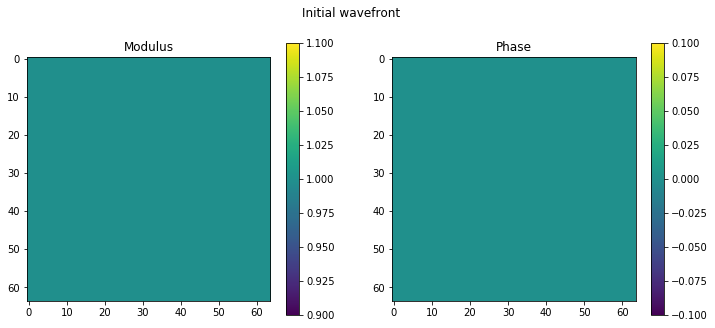

In [76]:
wavefront = initialize_wavefront(psize_cm, grid_delta.shape[0:2], lmbda_nm, type='plane')
plot_mod_and_phase(wavefront, title='Initial wavefront', unwrap=False)

  0%|          | 0/64 [00:00<?, ?it/s]

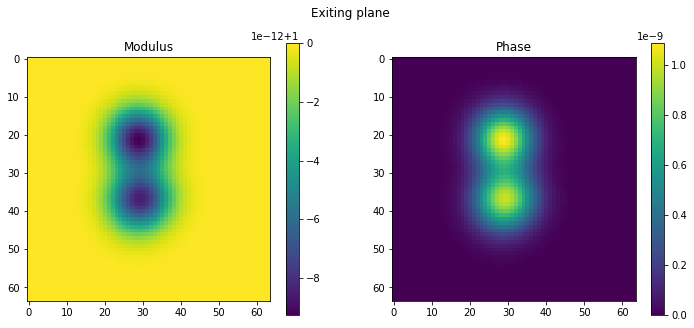

  2%|▏         | 1/64 [00:00<00:19,  3.30it/s]

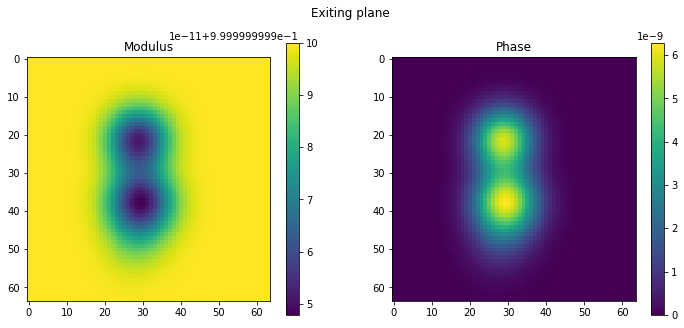

  3%|▎         | 2/64 [00:00<00:19,  3.19it/s]

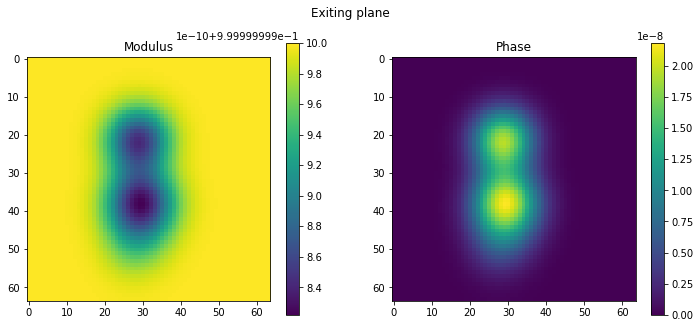

  5%|▍         | 3/64 [00:00<00:19,  3.16it/s]

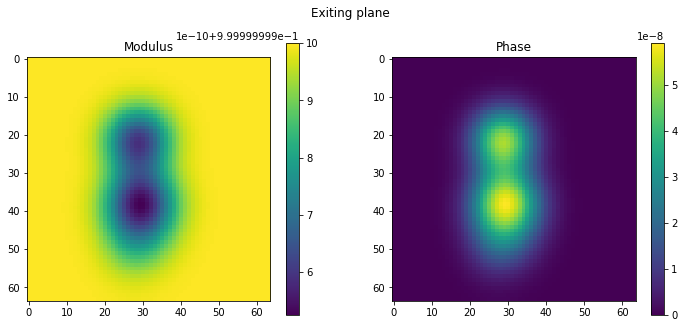

  6%|▋         | 4/64 [00:01<00:18,  3.22it/s]

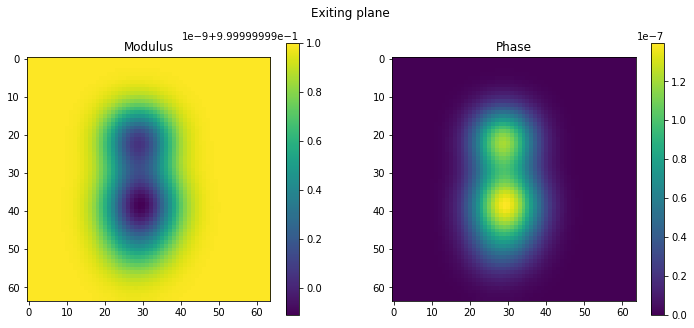

  8%|▊         | 5/64 [00:01<00:18,  3.21it/s]

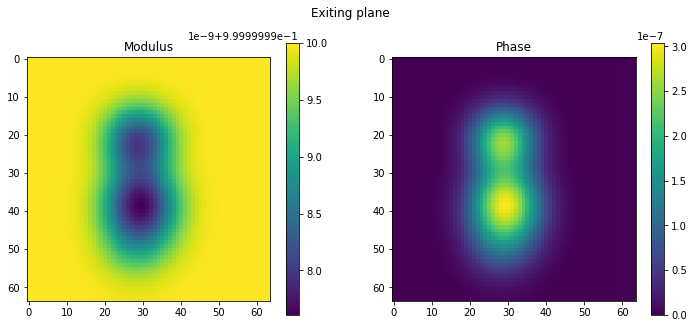

  9%|▉         | 6/64 [00:01<00:17,  3.22it/s]

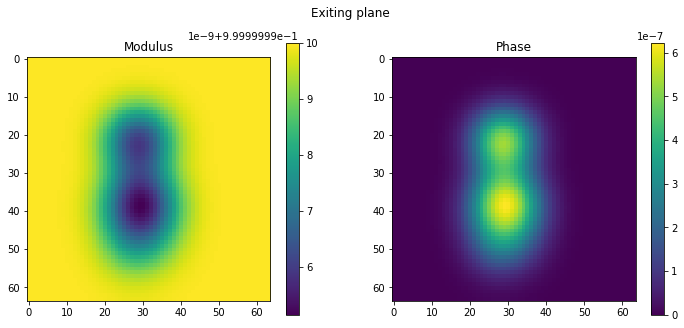

 11%|█         | 7/64 [00:02<00:17,  3.25it/s]

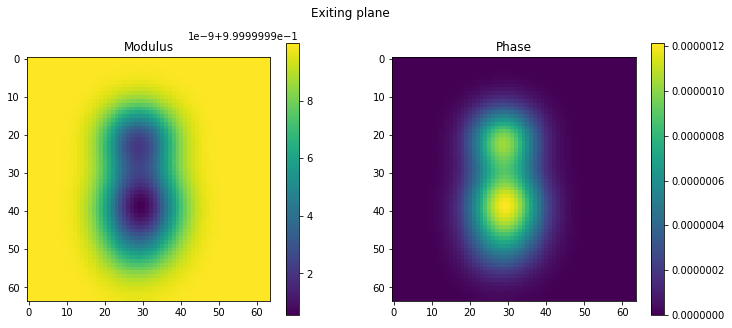

 12%|█▎        | 8/64 [00:02<00:17,  3.20it/s]

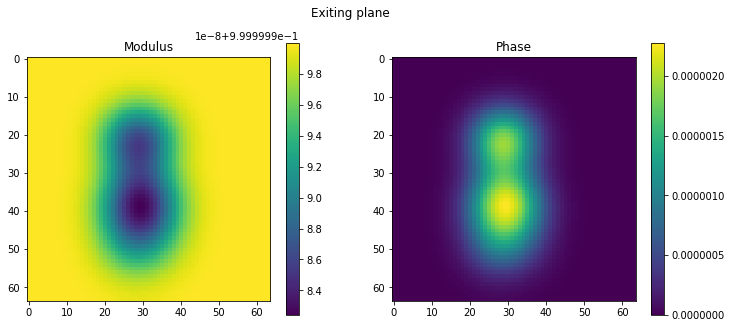

 14%|█▍        | 9/64 [00:02<00:17,  3.22it/s]

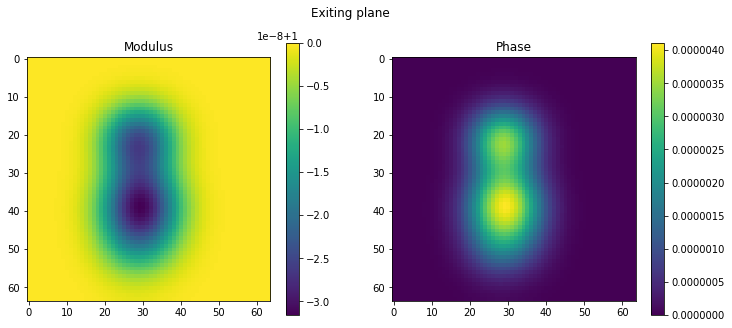

 16%|█▌        | 10/64 [00:03<00:16,  3.22it/s]

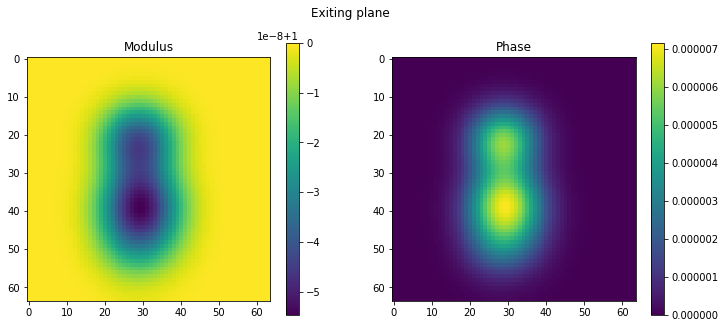

 17%|█▋        | 11/64 [00:03<00:16,  3.22it/s]

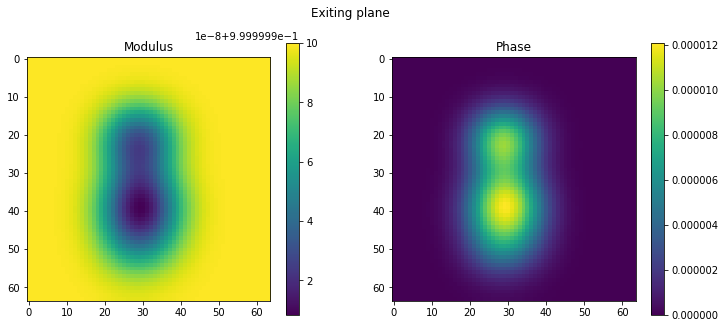

 19%|█▉        | 12/64 [00:03<00:16,  3.22it/s]

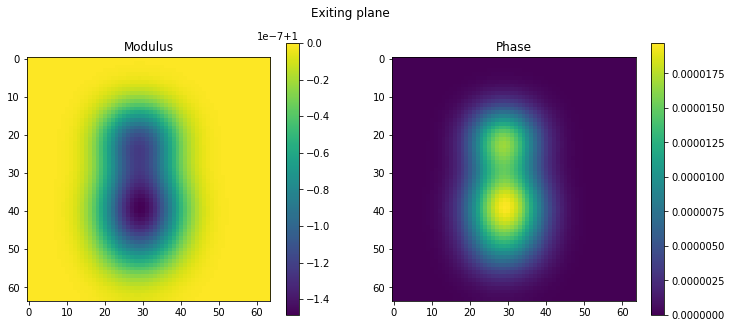

 20%|██        | 13/64 [00:04<00:16,  3.17it/s]

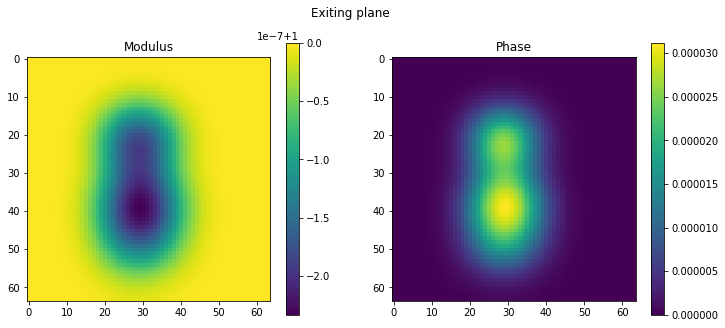

 22%|██▏       | 14/64 [00:04<00:15,  3.16it/s]

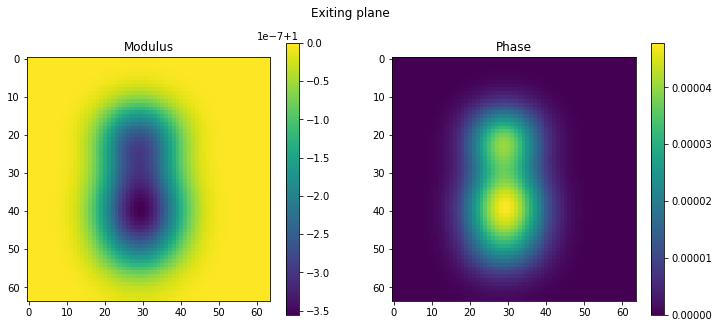

 23%|██▎       | 15/64 [00:04<00:15,  3.17it/s]

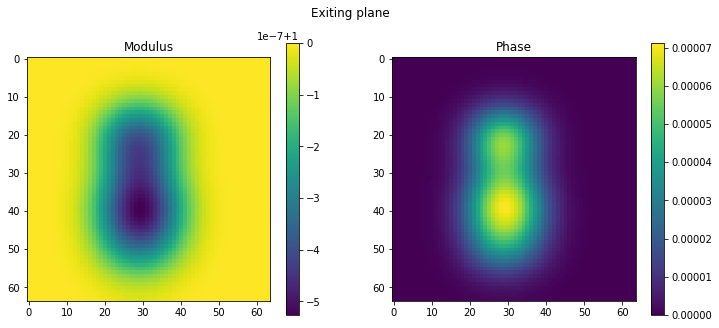

 25%|██▌       | 16/64 [00:05<00:15,  3.18it/s]

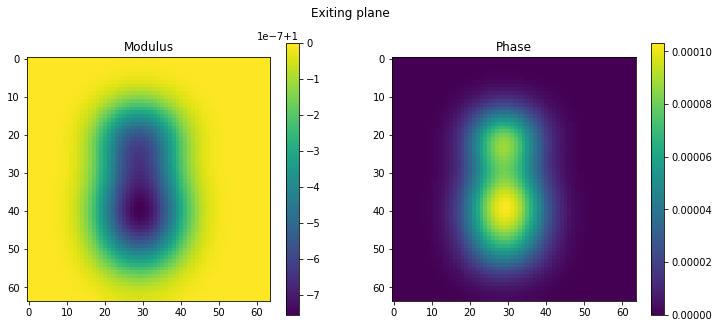

 27%|██▋       | 17/64 [00:05<00:14,  3.20it/s]

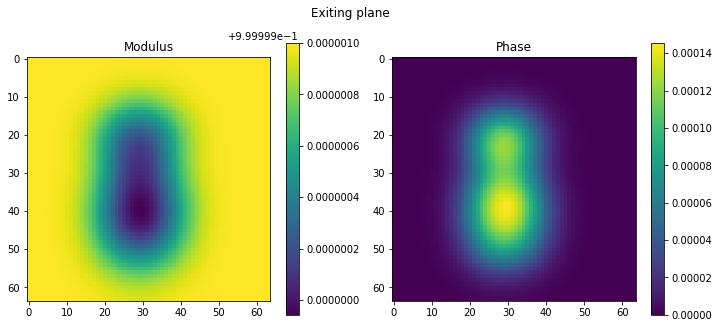

 28%|██▊       | 18/64 [00:05<00:14,  3.21it/s]

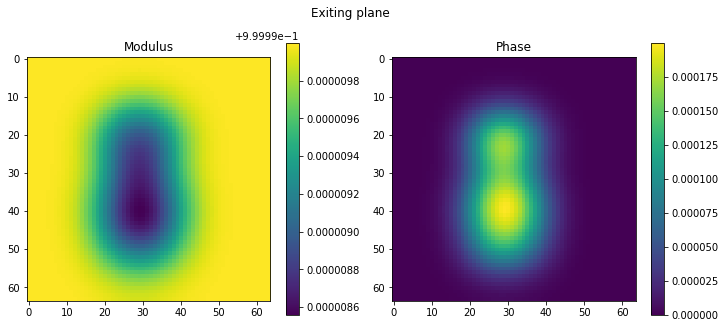

 30%|██▉       | 19/64 [00:05<00:14,  3.19it/s]

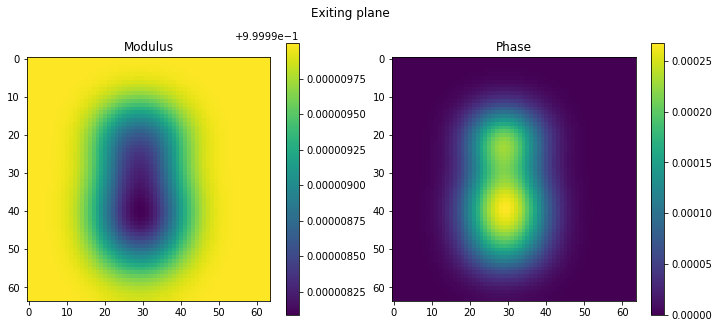

 31%|███▏      | 20/64 [00:06<00:13,  3.19it/s]

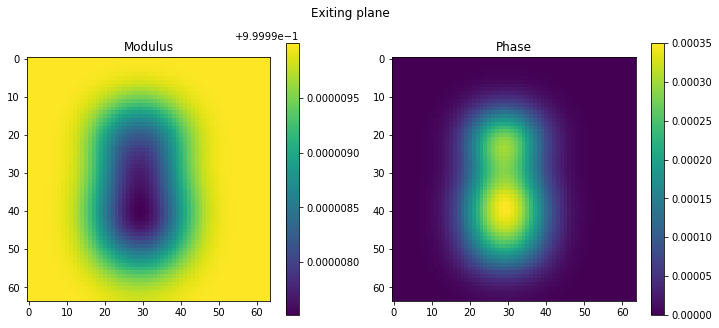

 33%|███▎      | 21/64 [00:06<00:13,  3.20it/s]

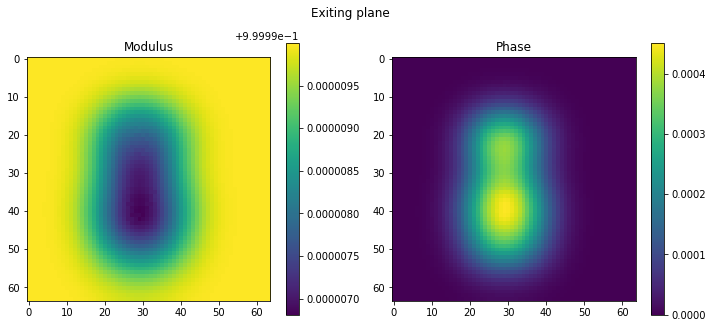

 34%|███▍      | 22/64 [00:06<00:13,  3.21it/s]

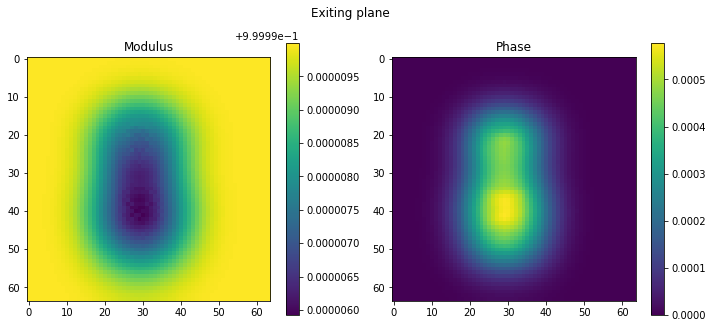

 36%|███▌      | 23/64 [00:07<00:12,  3.22it/s]

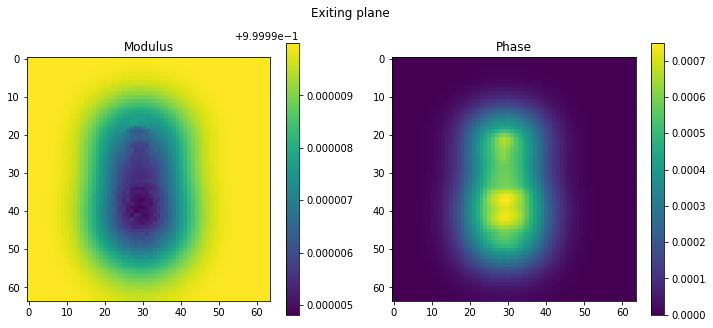

 38%|███▊      | 24/64 [00:07<00:12,  3.21it/s]

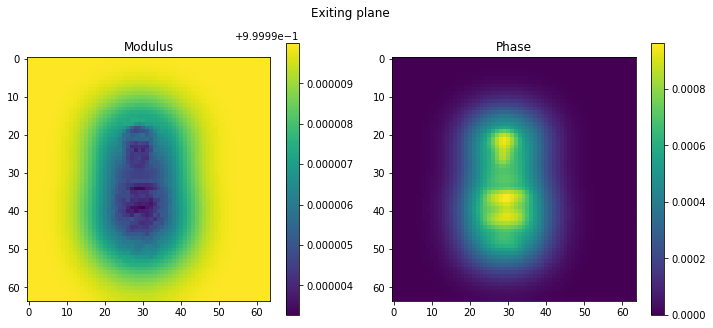

 39%|███▉      | 25/64 [00:07<00:12,  3.22it/s]

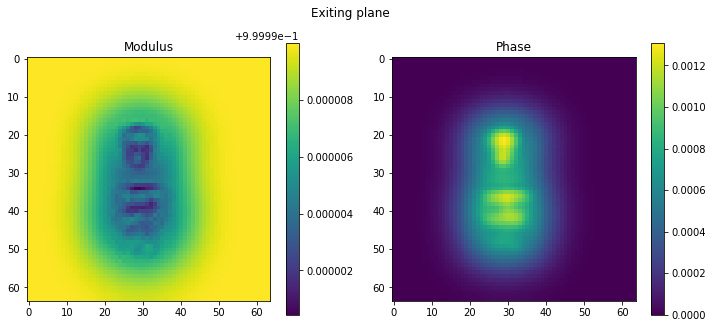

 41%|████      | 26/64 [00:08<00:11,  3.23it/s]

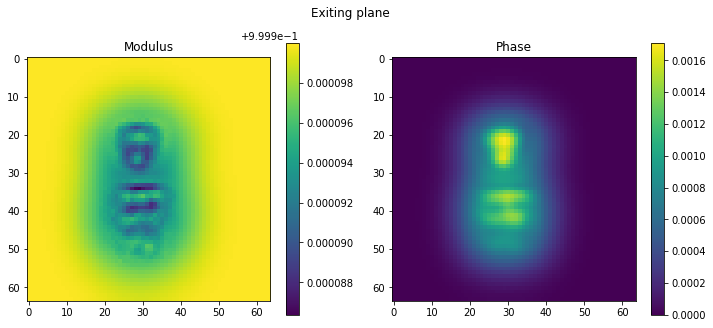

 42%|████▏     | 27/64 [00:08<00:11,  3.23it/s]

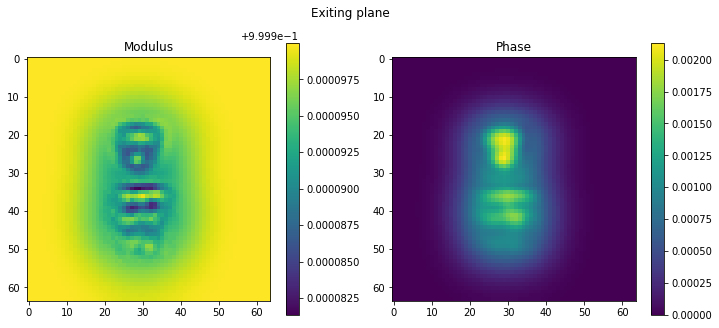

 44%|████▍     | 28/64 [00:08<00:11,  3.24it/s]

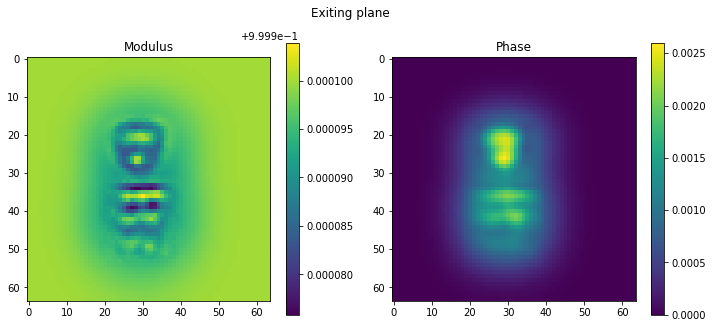

 45%|████▌     | 29/64 [00:08<00:10,  3.24it/s]

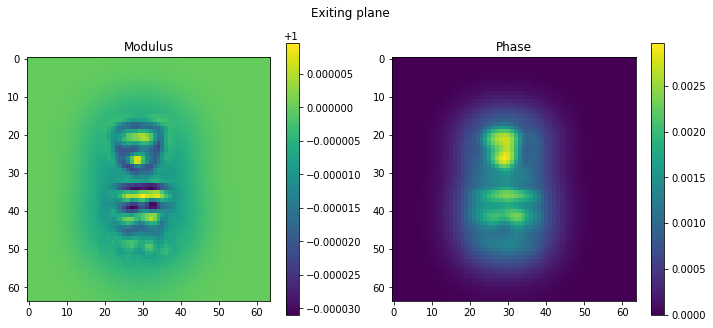

 47%|████▋     | 30/64 [00:09<00:10,  3.23it/s]

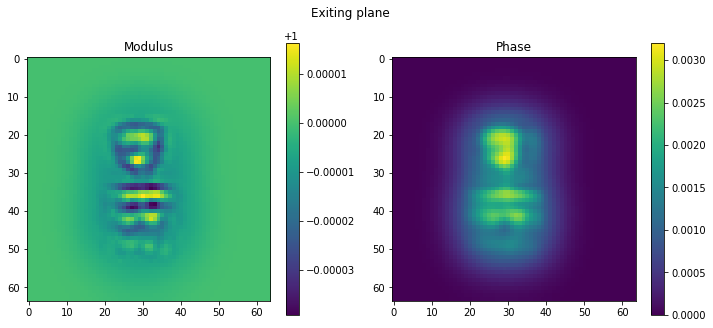

 48%|████▊     | 31/64 [00:09<00:10,  3.24it/s]

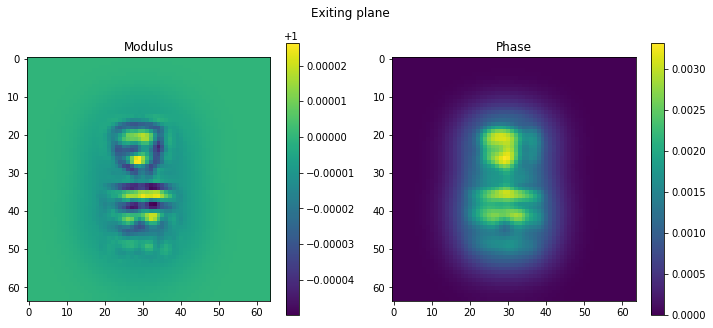

 50%|█████     | 32/64 [00:09<00:09,  3.25it/s]

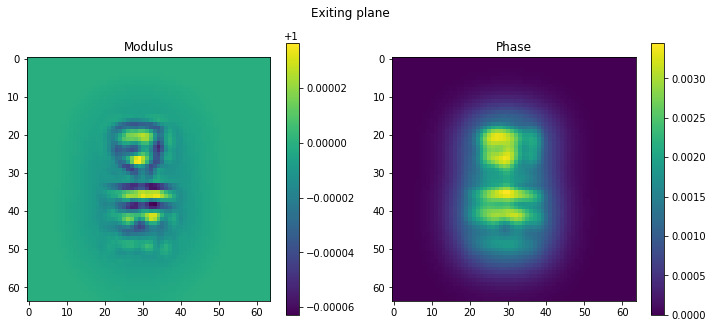

 52%|█████▏    | 33/64 [00:10<00:09,  3.25it/s]

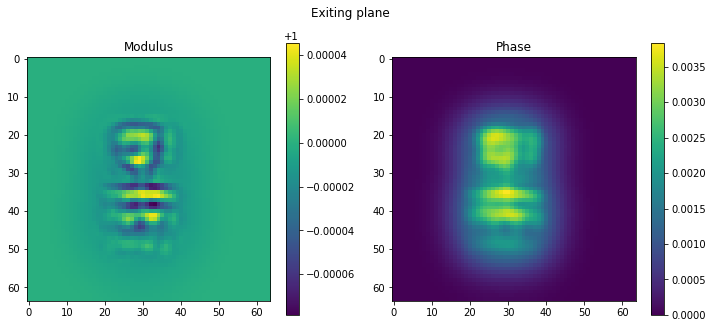

 53%|█████▎    | 34/64 [00:10<00:09,  3.26it/s]

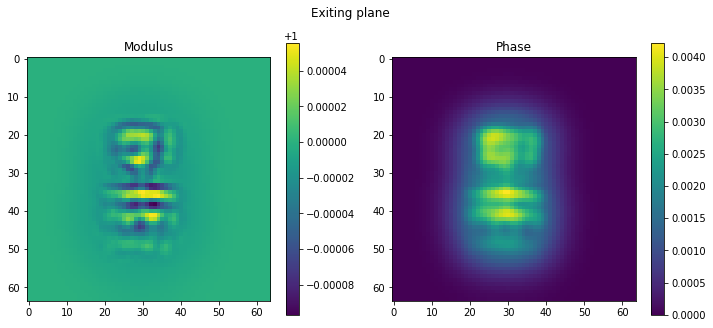

 55%|█████▍    | 35/64 [00:10<00:08,  3.25it/s]

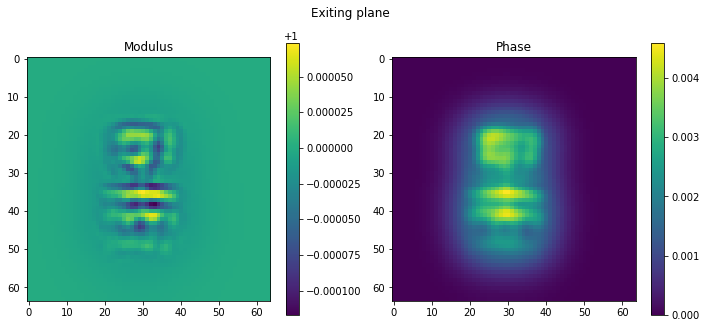

 56%|█████▋    | 36/64 [00:11<00:08,  3.25it/s]

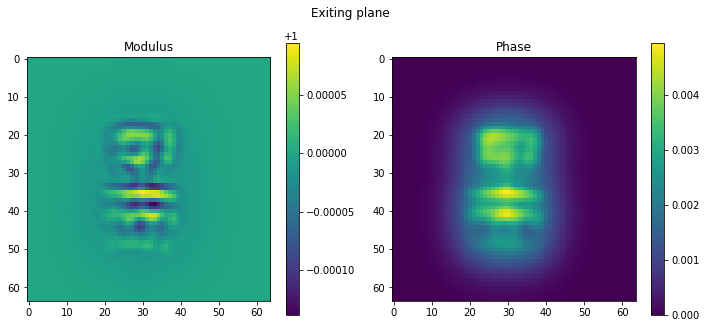

 58%|█████▊    | 37/64 [00:11<00:08,  3.26it/s]

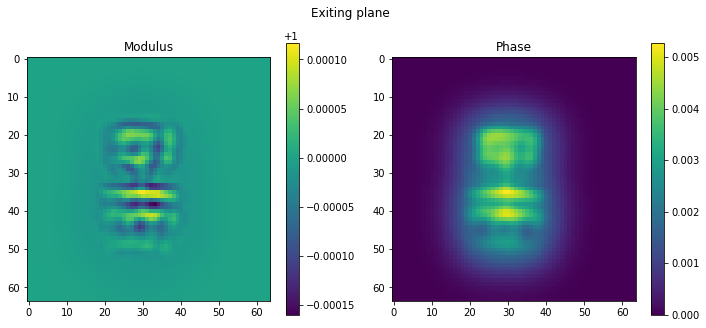

 59%|█████▉    | 38/64 [00:11<00:07,  3.27it/s]

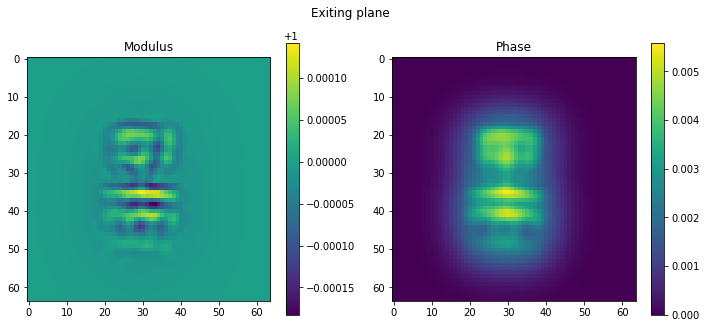

 61%|██████    | 39/64 [00:11<00:07,  3.27it/s]

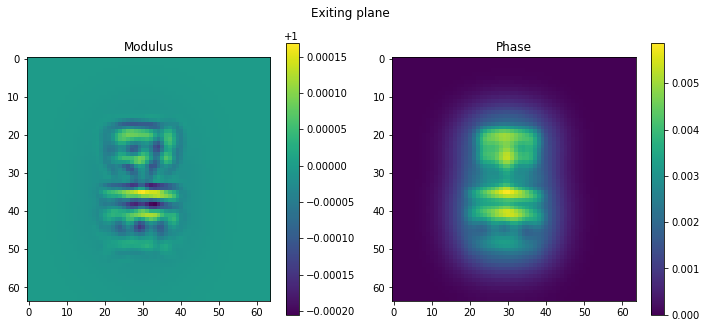

 62%|██████▎   | 40/64 [00:12<00:07,  3.28it/s]

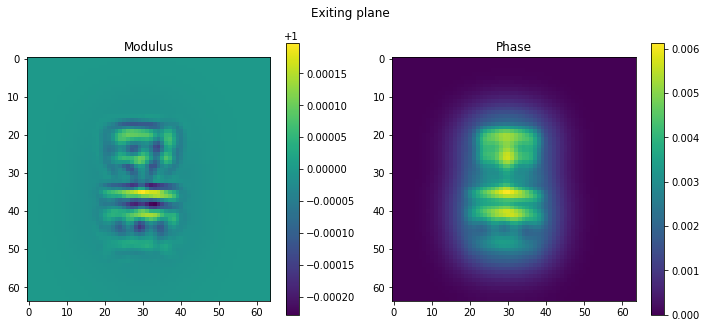

 64%|██████▍   | 41/64 [00:12<00:07,  3.27it/s]

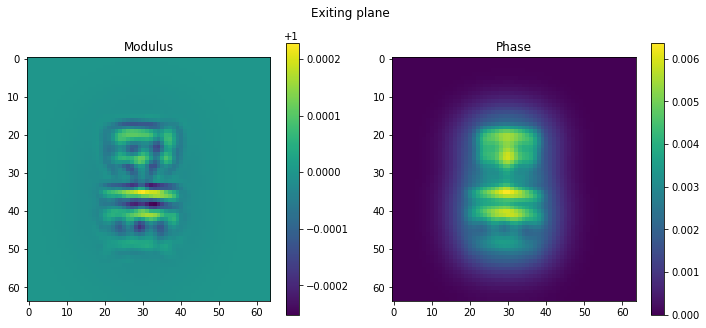

 66%|██████▌   | 42/64 [00:12<00:06,  3.28it/s]

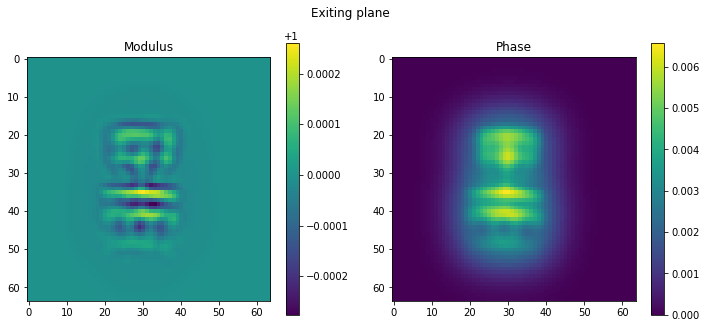

 67%|██████▋   | 43/64 [00:13<00:06,  3.28it/s]

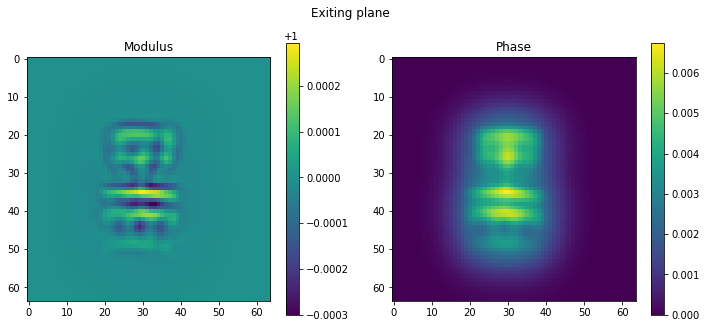

 69%|██████▉   | 44/64 [00:13<00:06,  3.28it/s]

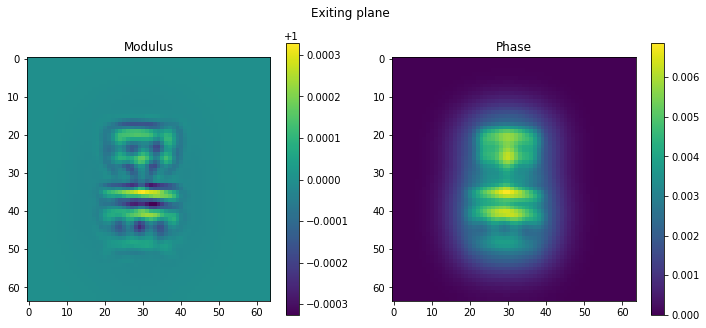

 70%|███████   | 45/64 [00:13<00:05,  3.29it/s]

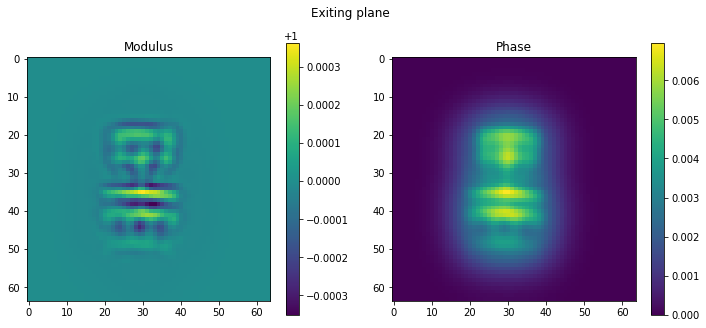

 72%|███████▏  | 46/64 [00:14<00:05,  3.28it/s]

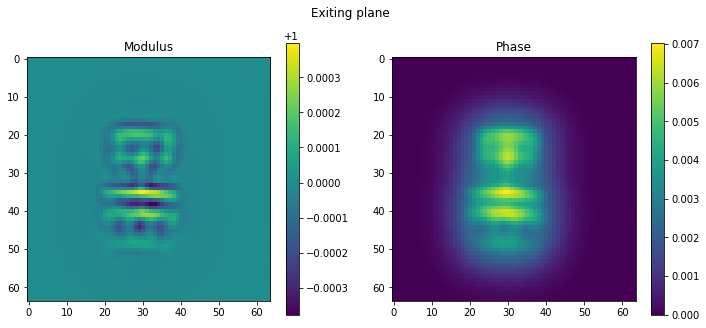

 73%|███████▎  | 47/64 [00:14<00:05,  3.28it/s]

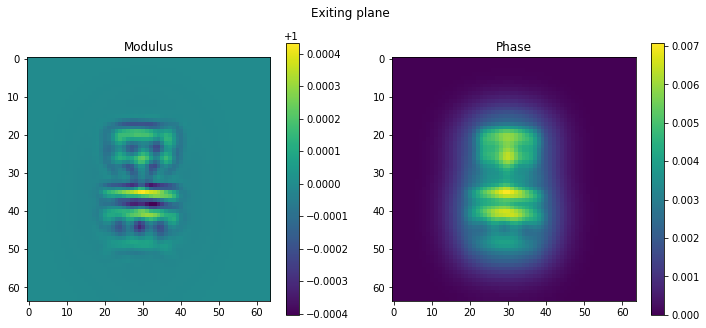

 75%|███████▌  | 48/64 [00:14<00:04,  3.28it/s]

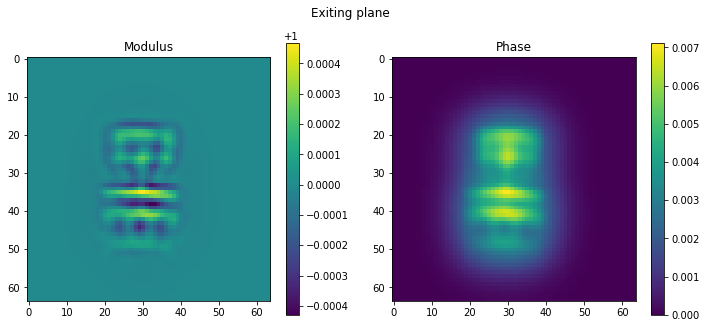

 77%|███████▋  | 49/64 [00:14<00:04,  3.28it/s]

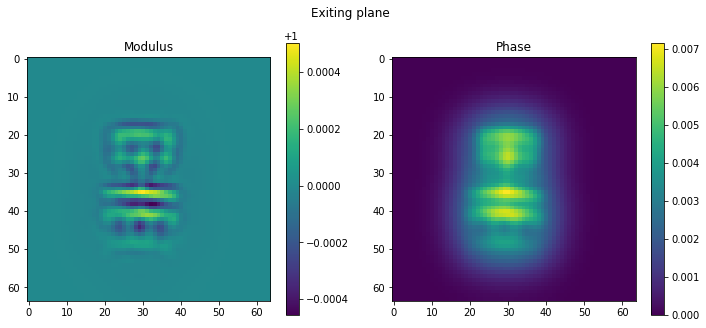

 78%|███████▊  | 50/64 [00:15<00:04,  3.29it/s]

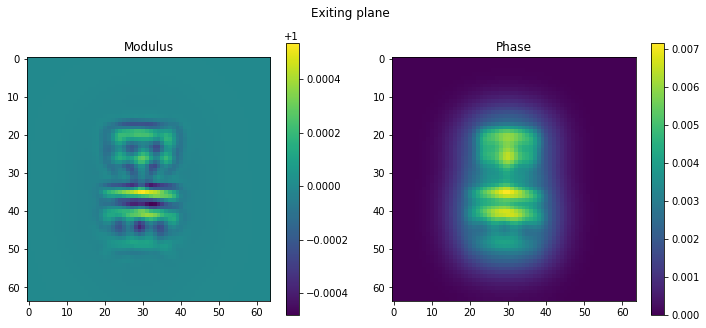

 80%|███████▉  | 51/64 [00:15<00:03,  3.29it/s]

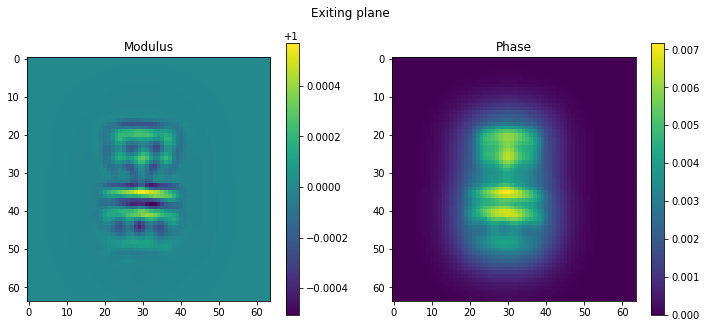

 81%|████████▏ | 52/64 [00:15<00:03,  3.29it/s]

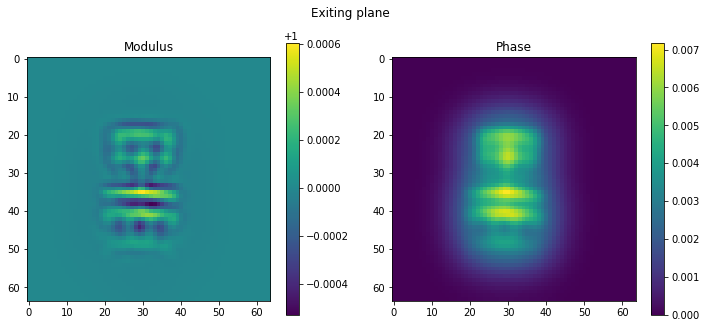

 83%|████████▎ | 53/64 [00:16<00:03,  3.29it/s]

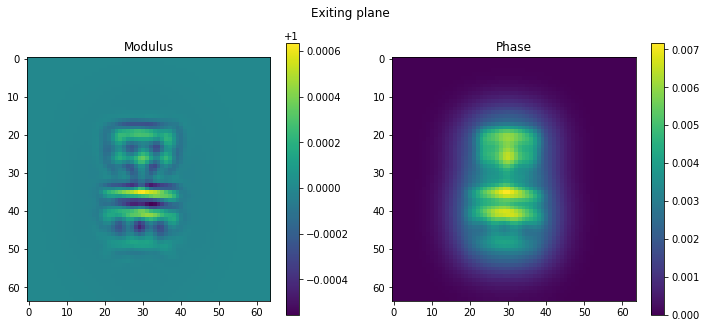

 84%|████████▍ | 54/64 [00:16<00:03,  3.29it/s]

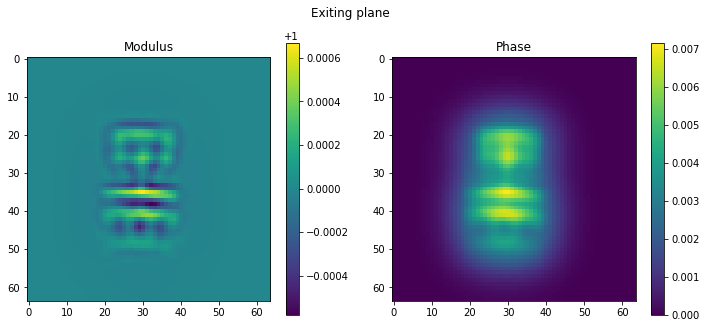

 86%|████████▌ | 55/64 [00:16<00:02,  3.29it/s]

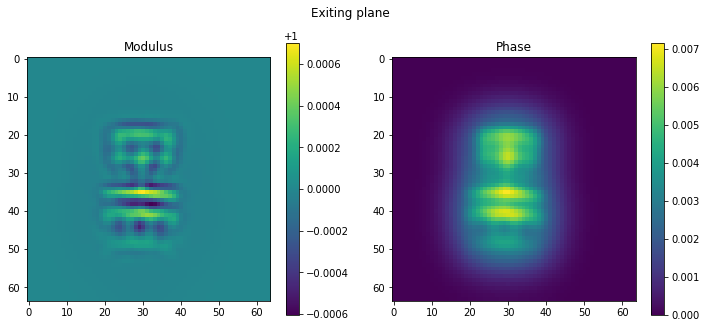

 88%|████████▊ | 56/64 [00:16<00:02,  3.30it/s]

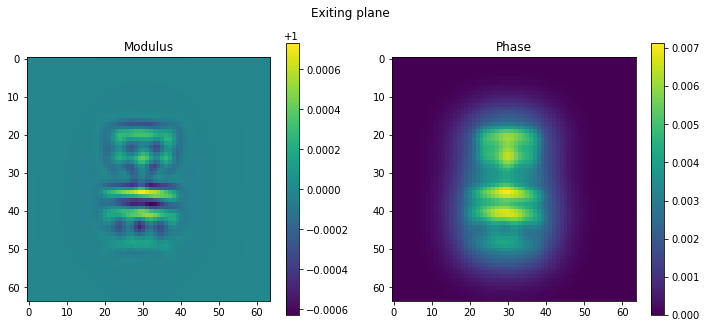

 89%|████████▉ | 57/64 [00:17<00:02,  3.29it/s]

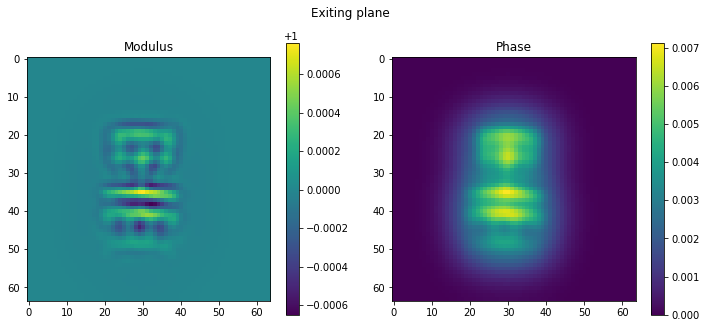

 91%|█████████ | 58/64 [00:17<00:01,  3.29it/s]

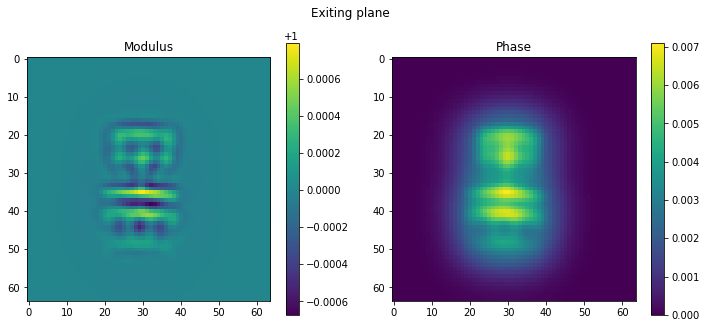

 92%|█████████▏| 59/64 [00:17<00:01,  3.29it/s]

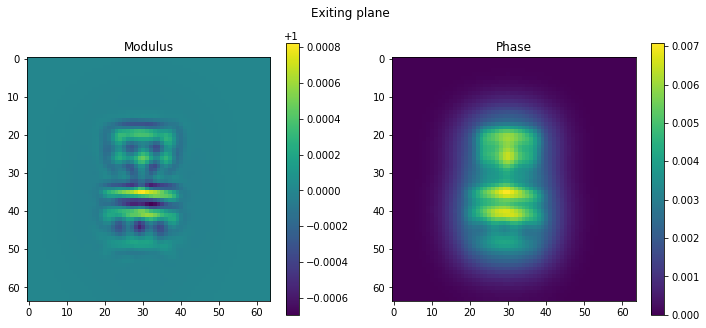

 94%|█████████▍| 60/64 [00:18<00:01,  3.30it/s]

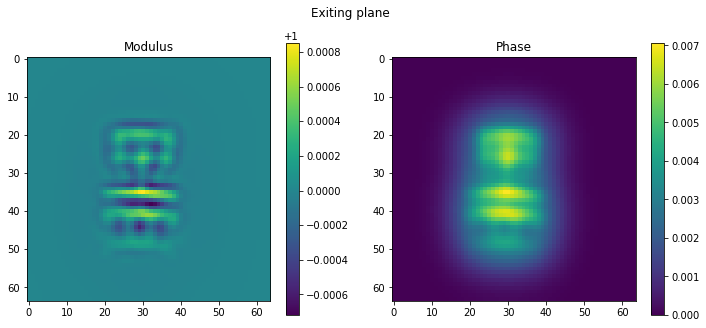

 95%|█████████▌| 61/64 [00:18<00:00,  3.30it/s]

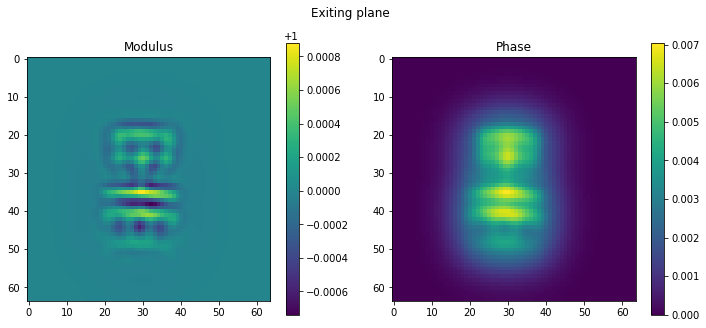

 97%|█████████▋| 62/64 [00:18<00:00,  3.30it/s]

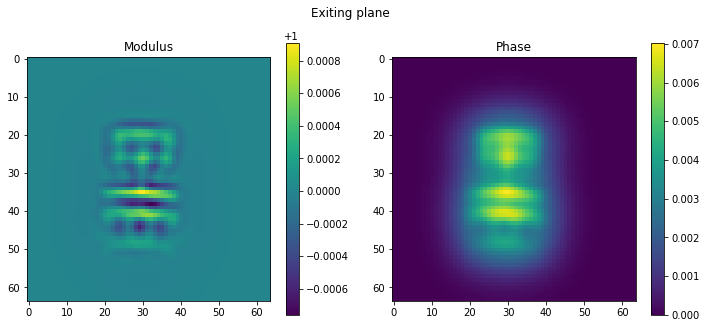

 98%|█████████▊| 63/64 [00:19<00:00,  3.28it/s]

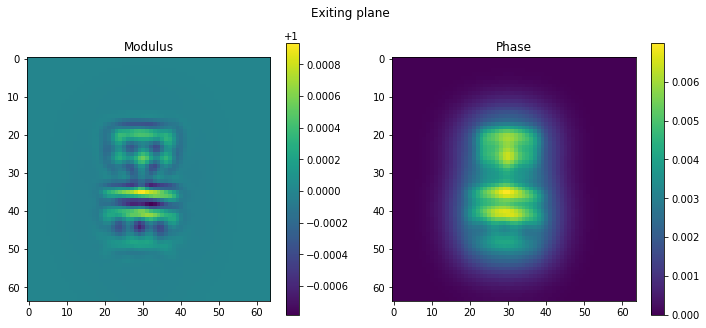

100%|██████████| 64/64 [00:19<00:00,  3.28it/s]


In [77]:
for i_slice in tqdm(range(grid_delta.shape[2])):
    delta_slice = grid_delta[:, :, i_slice]
    beta_slice = grid_beta[:, :, i_slice]
#     wavefront *= np.exp((kz * delta_slice) * 1j) * np.exp(-kz * beta_slice)
    wavefront = finite_difference_propagation(wavefront, 
                                              delta_slice,
                                              beta_slice,
                                              psize_nm, 
                                              lmbda_nm,
                                              psize_nm)
    plot_mod_and_phase(wavefront, title='Exiting plane', unwrap=False)

100%|██████████| 256/256 [00:00<00:00, 287.68it/s]


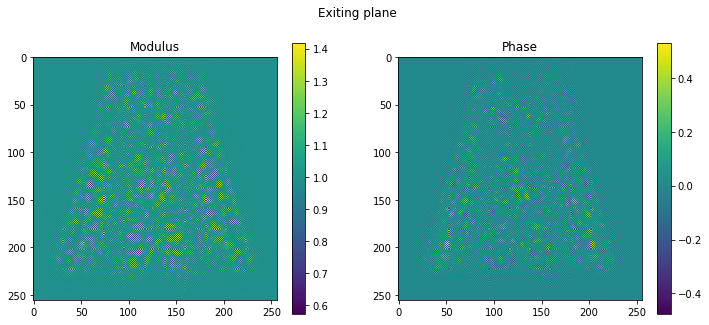

In [31]:
for i_slice in tqdm(range(grid_delta.shape[2])):
    delta_slice =  np.zeros([256, 256])
    beta_slice = np.zeros([256, 256])
    wavefront = finite_difference_propagation(wavefront, 
                                              delta_slice,
                                              beta_slice,
                                              psize_nm, 
                                              lmbda_nm,
                                              psize_nm)
plot_mod_and_phase(wavefront, title='Exiting plane', unwrap=False)